In [1]:
%%capture
! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
! git config --global credential.helper store

In [1]:

!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d nafishamoin/bangladeshi-crops-disease-dataset
!unzip -qq /content/bangladeshi-crops-disease-dataset.zip


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/nafishamoin/bangladeshi-crops-disease-dataset
License(s): copyright-authors
100% 6.44G/6.45G [01:39<00:00, 83.7MB/s]
100% 6.45G/6.45G [01:39<00:00, 69.3MB/s]


In [22]:

import requests
from concurrent.futures import ThreadPoolExecutor
#@title Hide cell { display-mode: "form" }
# Define download function
def download_file(url, file_name):
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(file_name, 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)
            print(f"Downloaded {file_name}")
        else:
            print(f"Failed to download {file_name} from {url}, Status code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred while downloading {file_name}: {e}")

# URLs and corresponding file names
urls = [
    #("https://data.mendeley.com/public-files/datasets/fkw49mz3xs/files/d520d003-ee5e-46ac-bdfe-3091496b46b0/file_downloaded", "MLN.zip"),
    #("https://data.mendeley.com/public-files/datasets/fkw49mz3xs/files/992c1710-e858-4af8-b1bc-e3c8d1652d90/file_downloaded", "MSV.zip"),
    #("https://data.mendeley.com/public-files/datasets/fkw49mz3xs/files/5dd32b08-bd7a-41bf-9800-a3b59095fd7c/file_downloaded", "HEALTHY.zip"),
    ("https://data.mendeley.com/public-files/datasets/wgd66f8n6h/files/4ec9266d-d7c1-4fd5-85c9-e5624c09a847/file_downloaded", "wheat_leaf.rar")
    ]

# Using ThreadPoolExecutor to download files concurrently
def download_files_concurrently(urls):
    with ThreadPoolExecutor(max_workers=len(urls)) as executor:
        # Submit download tasks to the thread pool
        futures = [executor.submit(download_file, url, file_name) for url, file_name in urls]

        # Wait for all downloads to complete
        for future in futures:
            future.result()  # Ensure that the downloads complete

if __name__ == "__main__":
    download_files_concurrently(urls)

Downloaded wheat_leaf.rar


In [7]:
# @title  unzip data { display-mode: "form"}
import shutil
import zipfile

def unzip_files(zip_file_name, destination_folder):
  try:
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
      zip_ref.extractall(destination_folder)
    print(f"Successfully extracted {zip_file_name} to {destination_folder}")
  except Exception as e:
    print(f"An error occurred while extracting {zip_file_name}: {e}")

!mkdir -p images

unzip_files("/content/bangladeshi-crops-disease-dataset.zip","images")


Successfully extracted /content/bangladeshi-crops-disease-dataset.zip to images


In [8]:
import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

## Init Dataset and Split into Training and Validation Sets


In [9]:
data_dir = Path('/content/CropDisease/Crop___DIsease')
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

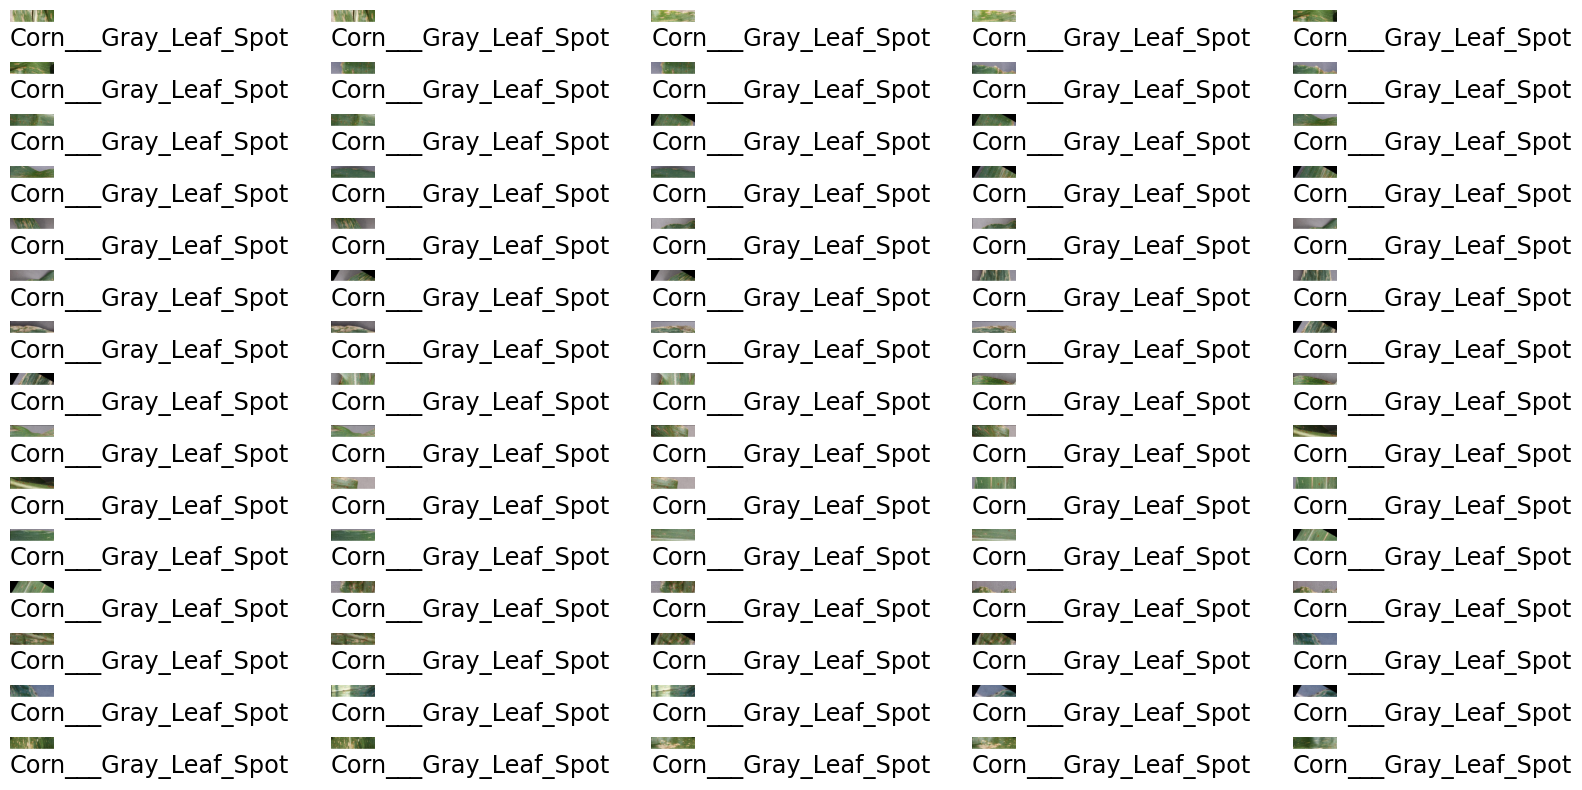

In [11]:
plt.figure(figsize=(20, 10))
num_examples_per_class = 5
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            # Check if we have exceeded the maximum number of subplots
            if i > len(ds.classes) * num_examples_per_class:
                break  # Exit the outer loop if we have filled all subplots
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break # Exit the inner loop for the current class

## Preparing Labels for Our Model's Config

By adding `label2id` + `id2label` to our model's config, we'll get friendlier labels in the inference API.

In [12]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [13]:
label2id

{'Corn___Common_Rust': '0',
 'Corn___Gray_Leaf_Spot': '1',
 'Corn___Healthy': '2',
 'Corn___Leaf_Blight': '3',
 'Invalid': '4',
 'Potato___Early_Blight': '5',
 'Potato___Healthy': '6',
 'Potato___Late_Blight': '7',
 'Rice___Brown_Spot': '8',
 'Rice___Healthy': '9',
 'Rice___Hispa': '10',
 'Rice___Leaf_Blast': '11',
 'Wheat___Brown_Rust': '12',
 'Wheat___Healthy': '13',
 'Wheat___Yellow_Rust': '14'}

## Image Classification Collator

To apply our transforms to images, we'll use a custom collator class. We'll initialize it using an instance of `ViTFeatureExtractor` and pass the collator instance to `torch.utils.data.DataLoader`'s `collate_fn` kwarg.

In [14]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings

## Init Feature Extractor, Model, Data Loaders


In [15]:
feature_extractor = ViTFeatureExtractor.from_pretrained('WinKawaks/vit-tiny-patch16-224')
model = ViTForImageClassification.from_pretrained(
    'WinKawaks/vit-tiny-patch16-224',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([15, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training

⚡ We'll use [PyTorch Lightning](https://pytorchlightning.ai/) to fine-tune our model.

In [16]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(
            task='multiclass' if model.config.num_labels > 2 else 'binary',
            num_classes=model.config.num_labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator='gpu', devices=1, precision=16, max_epochs=4)
trainer.fit(classifier, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                      | Params | Mode 
--------------------------------------------------------------
0 | model   | ViTForImageClassification | 5.5 M  | eval 
1 | val_acc | MulticlassAccuracy        | 0      | train
------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

## Check if it Worked 😅

In [15]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

Preds:  tensor([2, 1, 1, 1, 1, 1, 1, 2])
Labels: tensor([2, 1, 1, 1, 1, 1, 1, 2])


In [20]:
from PIL import Image
image = Image.open('/content/leaf-maize-close-up-tender-scientific-name-zea-mays-188920630.jpg')
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[str(predicted_class_idx)])

Predicted class: HEALTHY


In [21]:
model.push_to_hub("wambugu1738/maize_diseases_vit")

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/wambugu1738/maize_diseases_vit/commit/536c39e5f85d21224e5f3087c5678805907c5c22', commit_message='Upload ViTForImageClassification', commit_description='', oid='536c39e5f85d21224e5f3087c5678805907c5c22', pr_url=None, pr_revision=None, pr_num=None)

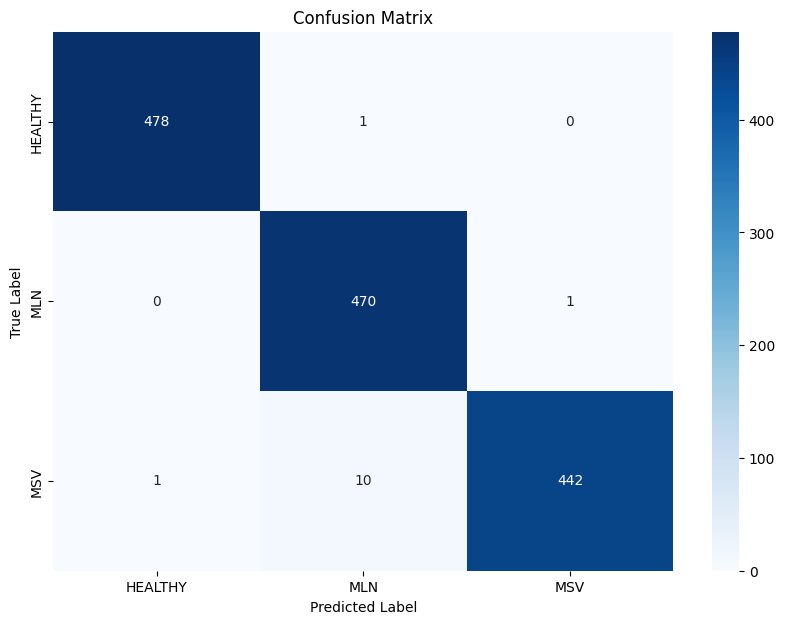

              precision    recall  f1-score   support

     HEALTHY       1.00      1.00      1.00       479
         MLN       0.98      1.00      0.99       471
         MSV       1.00      0.98      0.99       453

    accuracy                           0.99      1403
   macro avg       0.99      0.99      0.99      1403
weighted avg       0.99      0.99      0.99      1403



In [23]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
# Get predictions and true labels for the validation set
all_preds = []
all_labels = []
for batch in val_loader:
    outputs = model(**batch)
    preds = outputs.logits.argmax(1).cpu().numpy()
    labels = batch['labels'].cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels)

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ds.classes, yticklabels=ds.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=ds.classes)
print(report)